In [5]:
import os
from typing import List, Annotated
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [6]:
llm=init_chat_model("openai:gpt-4o")

In [7]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [8]:
## Recursive character text ssplitter an vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [9]:
# -----------------------------
# 2. Define RAG State
# -----------------------------

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [10]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)

def generate_answer(state: RAGState) -> RAGState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

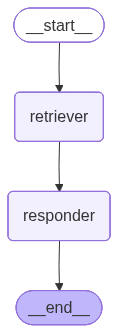

In [11]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------

builder = StateGraph(RAGState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [12]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n✅ Final Answer:\n", final_state['answer'])


✅ Final Answer:
 The context does not explicitly define the concept of an "agent loop" in autonomous agents. However, based on the general understanding of autonomous agents and the information provided about generative agents, an "agent loop" could refer to the iterative process these agents undergo, involving memory, planning, and reflection mechanisms. This loop allows the agent to utilize past experiences (memory), strategize for future actions (planning), and assess or adjust its actions based on outcomes (reflection). This iterative cycle or loop enables autonomous agents to continuously refine their behavior and improve performance over time.


In [13]:
final_state

{'question': 'What is the concept of agent loop in autonomous agents?',
 'retrieved_docs': [Document(id='73b94b64-656c-4aae-a70b-85dca142099c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism an